
## 2. Somehow able to read data in these images and convert it to row and column format, so that the data can be inserted into database:  

To have a full-fledged solution for this part is really difficult task. For that reason, you 
are expected here to make a working solution for only the images mentioned in 
dataset_part2 (contains 2 bar graph plots).  You can have different code that works 
for  different images. 

Make use of existing OCR engines  to extract the information in the given images. 

__Tasks:__
- a) Extract and print  ‘title of graph’ and make bounding boxes around the texts detected in the images and save the resultant images with Bounding boxes.Save images as ’ {image_name}_bboxes.png’ 
- b) Make use of computer vision skills, get individual bars and their values (Hint : contour detection, edge detection etc). Write the individual results into ‘{image_name}.csv’  


__Deliverables:__  
- 4. Complete code or notebook .
- 5. Documentation containing instructions to run your code and a requirements.txt file (You can also make use of Markdown cells if you are using a notebook) 

__Resources for part 2:__
- a) The easiest way to get started is using EasyOCR (https://pypi.org/project/easyocr/) . 
- b) Look at cv2 contour detection, edge detection, corner detection. (Feel free to ask and discuss approaches on the graph2table teams channel)

### Install pytesseract if not already installed

### Add all necessary imports

In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import pytesseract
import csv
import pandas as pd

## b) Make use of computer vision skills, get individual bars and their values (Hint : contour detection, edge detection etc). Write the individual results into ‘{image_name}.csv’  

### First detect the graph so that we can crop to that level for easy detection

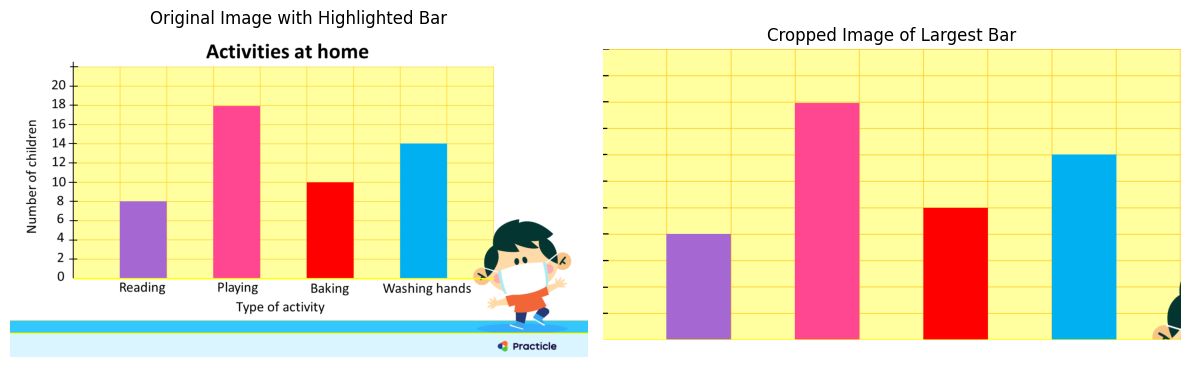

In [164]:
# Load and adjust the image
image_path = os.path.join('dataset_part2', 'image_2.png')
image = cv2.imread(image_path)
output = image.copy()

# Convert to HSV to isolate colored bars better
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define a mask to isolate all strong color regions (ignoring yellow bg)
# We'll keep saturation and value high to exclude light yellow
lower = np.array([0, 100, 100])
upper = np.array([179, 255, 255])
mask = cv2.inRange(hsv, lower, upper)

# Morph to remove small gaps/noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bars = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 50 and w > 20 and y > 50:  # basic bar-like filtering
        bars.append((x, y, w, h))
        cv2.line(output, (x, y + h), (x + w, y + h), (0, 255, 255), 2)


# Highlight the largest bar
if bars:
    largest = max(bars, key=lambda b: b[2] * b[3])
    # Crop the image to the size of the largest bar
    x, y, w, h = largest  # Coordinates of the largest bar
    cropped_image = output[y:y + h, x:x + w]
    
    # Save crop info for later use
    crop_info = {
    "x": x,
    "y": y,
    "w": w,
    "h": h
}

else:
    print("No bars detected. Skipping largest bar highlighting.")

# Display the original image with the highlighted bar and the cropped version
plt.figure(figsize=(12, 6))

# Original image with highlighted bar
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Original Image with Highlighted Bar")
plt.axis('off')

# Cropped image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title("Cropped Image of Largest Bar")
plt.axis('off')

plt.tight_layout()
plt.show()

### Now we will use the cropped image to detect the 4 bars and get the bboxes of them and then save those values for later.

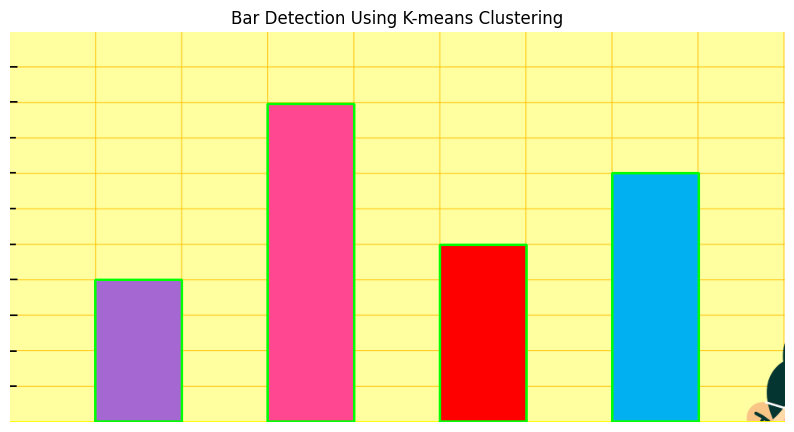

In [165]:
# Use k-means clustering to segment the image by color and isolate the bars more reliably
Z = cropped_image.reshape((-1, 3))
Z = np.float32(Z)

# Define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4  # number of color clusters
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to uint8 and reshape to original image
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((cropped_image.shape))

# Convert to grayscale and threshold to isolate the bars
gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
_, thresh_segmented = cv2.threshold(gray_segmented, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours again
contours_final, _ = cv2.findContours(thresh_segmented, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw only valid bar-like bounding boxes
final_boxed_image = cropped_image.copy()
detected_bars = []
for cnt in contours_final:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = h / float(w)
    if w > 10 and h > 100 and aspect_ratio > 1.5:
        detected_bars.append((x, y, w, h))
        cv2.rectangle(final_boxed_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Convert for display
final_boxed_rgb = cv2.cvtColor(final_boxed_image, cv2.COLOR_BGR2RGB)

# Display corrected result
plt.figure(figsize=(10, 6))
plt.imshow(final_boxed_rgb)
plt.title("Bar Detection Using K-means Clustering")
plt.axis("off")
plt.show()


### Now use the crop info to calculate the correct coordinates relative to the original image

In [166]:
bars_in_original_image = []
for (x, y, w, h) in detected_bars:
    original_x = crop_info['x'] + x
    original_y = crop_info['y'] + y
    bars_in_original_image.append((original_x, original_y, w, h))

### Now check all the detected bars

In [167]:
# Exclude the biggest detected bar
detected_bars_data = []
max_area = max(bars_in_original_image, key=lambda bar: bar[2] * bar[3])  # Find the bar with the largest area

for (x, y, w, h) in bars_in_original_image:  # Exclude the largest bar
    detected_bars_data.append({
        'x': x,
        'y': y,
        'width': w,
        'height': h
    })

# Sort detected bars data by x-axis
detected_bars_data_sorted = sorted(detected_bars_data, key=lambda bar: bar['x'])

print("Detected bars data sorted by x-axis:")
for bar in detected_bars_data_sorted:
    print(bar)

Detected bars data sorted by x-axis:
{'x': 243, 'y': 375, 'width': 104, 'height': 170}
{'x': 450, 'y': 164, 'width': 104, 'height': 381}
{'x': 657, 'y': 333, 'width': 104, 'height': 212}
{'x': 864, 'y': 247, 'width': 104, 'height': 298}


### Find different ways to extract values

In [168]:
# Define the highest and first bar values
first_value = 8

# Get the height of the highest bar and the first bar
highest_bar_height = max(detected_bars_data_sorted, key=lambda bar: bar['height'])['height']
first_bar_height = detected_bars_data_sorted[0]['height']

# Calculate the scale factor
scale_factor = first_value / first_bar_height

# Calculate the values for the rest of the bars
bar_values = []
for bar in detected_bars_data_sorted:
    value = round(bar['height'] * scale_factor, 1)
    bar_values.append(value)

print("Calculated bar values:", bar_values)

Calculated bar values: [8.0, 17.9, 10.0, 14.0]


### Now find a way to detect the text under the bars


In [169]:
# Ensure Tesseract is installed and added to PATH
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Dictionary to store bar coordinates and detected text
bar_text_mapping = {}

for bar in detected_bars_data_sorted:
    x, y, width, height = bar['x'], bar['y'], bar['width'], bar['height']
    
    # Define ROI below the bar (adjust the height as needed)
    roi_y_start = y + height + 10  # Start 10 pixels below the bar
    roi_y_end = roi_y_start + 50   # Define height of the ROI

    # Add a margin to the left and right of the bar's bounding box
    margin = 50 # Adjust margin as needed
    roi_x_start = max(0, x - margin)  # Ensure it doesn't go out of bounds
    roi_x_end = min(image.shape[1], x + width + margin)  # Ensure it doesn't go out of bounds

    # Extract the ROI with the expanded width
    roi = image[roi_y_start:roi_y_end, roi_x_start:roi_x_end]
    
    # Perform OCR on the ROI
    detected_text = pytesseract.image_to_string(roi, config='--psm 6').strip()
    
    # Map the detected text to the bar
    bar_text_mapping[(x, y, width, height)] = detected_text

# Print the mapping of bars to detected text
for bar, text in bar_text_mapping.items():
    print(f"Bar at {bar} has text: '{text}'")


Bar at (243, 375, 104, 170) has text: 'Reading'
Bar at (450, 164, 104, 381) has text: 'Playing'
Bar at (657, 333, 104, 212) has text: 'Baking'
Bar at (864, 247, 104, 298) has text: 'Washing hands'


### There was an issue because the text under the bar was outside of the reading range. To fix this I added an margin

### Now combine the code

In [170]:
# Define the output CSV file path
output_csv_path = 'bar_values_image_2_v1.csv'

# Combine bar text and values into rows
rows = [{'Bar Text': bar_text_mapping[(bar['x'], bar['y'], bar['width'], bar['height'])], 'Value': value} for bar, value in zip(detected_bars_data_sorted, bar_values)]

# Write to CSV
with open(output_csv_path, mode='w', newline='') as csv_file:
    fieldnames = ['Bar Text', 'Value']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(rows)

print(f"CSV file '{output_csv_path}' created successfully.")

# Print final values in a df
df = pd.DataFrame(rows)
print(df)

CSV file 'bar_values_image_2_v1.csv' created successfully.
        Bar Text  Value
0        Reading    8.0
1        Playing   17.9
2         Baking   10.0
3  Washing hands   14.0
